In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor as forest
from sklearn.linear_model import LinearRegression as linear
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
import matplotlib as mpl
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Import files and Data cleaning 

In [5]:
listing_b=pd.read_csv('listings_boston.csv')
review_b=pd.read_csv('reviews_boston.csv')
calendar_b=pd.read_csv('calendar_boston.csv')
calendar_b=calendar_b.drop_duplicates(keep='first')

#remove rows with missing price,drop columns with over 90% missing values and columns with all same values in it
listing_b=listing_b.dropna(subset=['price'])
listing_b=listing_b.drop(columns=[i for i in listing_b.columns if len(listing_b[i].value_counts())==1])
listing_b=listing_b.drop(columns=listing_b.columns[listing_b.isnull().sum()/len(listing_b)>0.9])

# remove dollar sign and change data type to float
listing_b=listing_b.apply(lambda x: x.str.replace('$',"").str.replace(',','').astype('float') if x.dtypes=='O' and \
                          x.str.contains('$',regex=False).sum()== x.notnull().sum()  else x)
listing_b['host_response_rate'] = listing_b['host_response_rate'].str.replace('%','').astype('float')
listing_b['host_acceptance_rate'] = listing_b['host_acceptance_rate'].str.replace('%','').astype('float')
listing_b=listing_b.dropna(subset=['bedrooms','bathrooms','beds'])


# Listing price changes analysis

Text(0.5, 1.0, 'Average listing price change during Sept 2016 - Sept 2017')

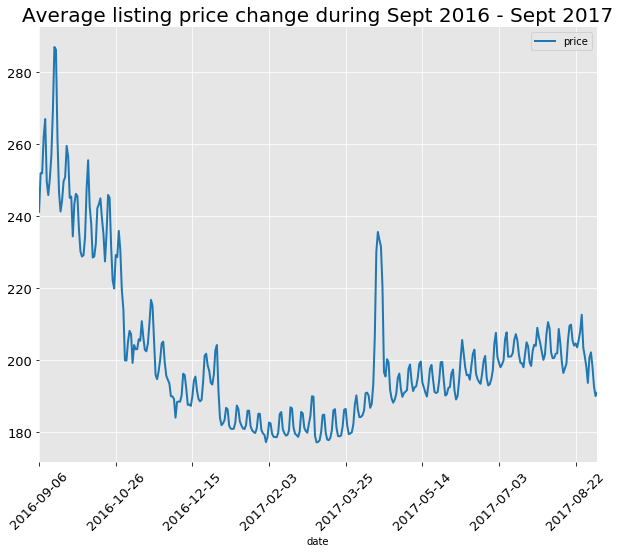

In [6]:
#drop rows with no price and remove dollar sign in Calendar 
calendar_f=calendar_b.dropna(subset = ["price"])
calendar_f["price"] = calendar_f["price"].map(lambda x: x.replace("$",'').replace(",",''), na_action = 'ignore').astype(float)

# plot average listing price change throughout the year
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')
calendar_f.groupby('date').mean().reset_index().plot(kind='line',x='date',y='price',linewidth=2,rot=45,fontsize=13,figsize=(10,8))
plt.title('Average listing price change during Sept 2016 - Sept 2017',size=20)

Text(0.5, 1.0, 'Avg % of booked properties change during Sept 2016 - Sept 2017')

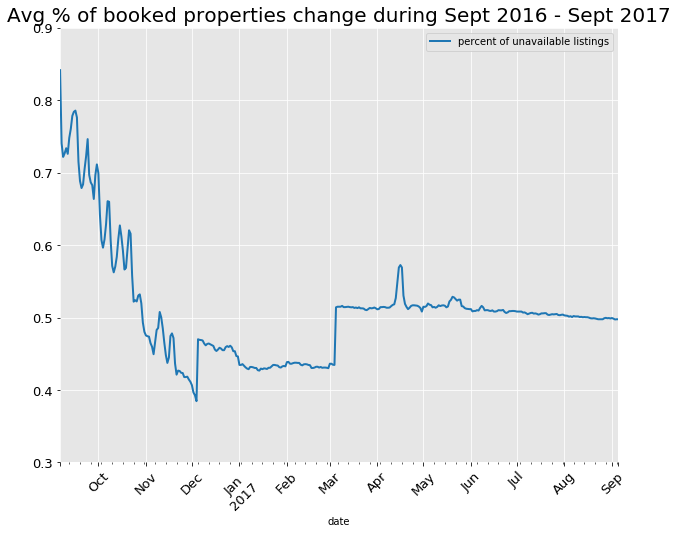

In [21]:
# drop duplicated records in dataset
calendar_all=calendar_b.drop_duplicates(keep='first')
calendar_all.date=pd.to_datetime(calendar_all.date)

#calculate average percent of booked properities througout the year
unava=calendar_all.loc[calendar_all.available=='f'].groupby(['date']).count()['listing_id']
total=calendar_all.groupby(['date']).count()['listing_id']
temp=pd.concat([unava,total],axis=1)
temp.columns=['listing_id','listing_id1']
temp.fillna(0,inplace=True)
temp=temp.reset_index()

temp['percent of unavailable listings']=temp['listing_id']/temp['listing_id1']

temp.groupby('date').mean().reset_index().sort_values(by='date').plot(x='date',y='percent of unavailable listings',figsize=(10,8),
                                                                            ylim=[0.3,0.9],rot=45,fontsize=13,linewidth=2)
plt.title('Avg % of booked properties change during Sept 2016 - Sept 2017',size=20)

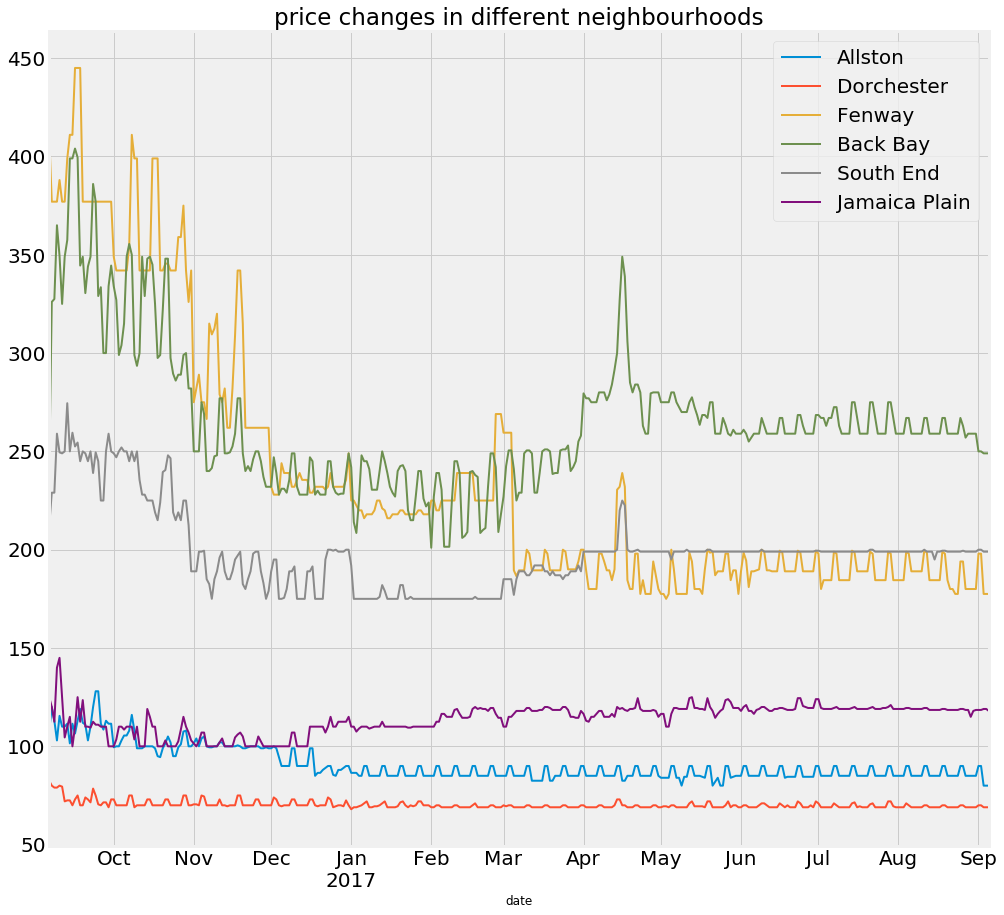

In [1005]:
#plot price change for top 6 neighbourhoods
price=popular.loc[popular.available=='t'].groupby(['date','neighbourhood_cleansed']).median()['price']
price=price.reset_index()

price=price.pivot(columns='neighbourhood_cleansed',index='date',values='price')
price[['Allston','Dorchester','Fenway','Back Bay','South End','Jamaica Plain']].plot(figsize=(15,15),legend=True,linewidth=2)
plt.title('price changes in different neighbourhoods',size=23)
plt.legend(fontsize=20)

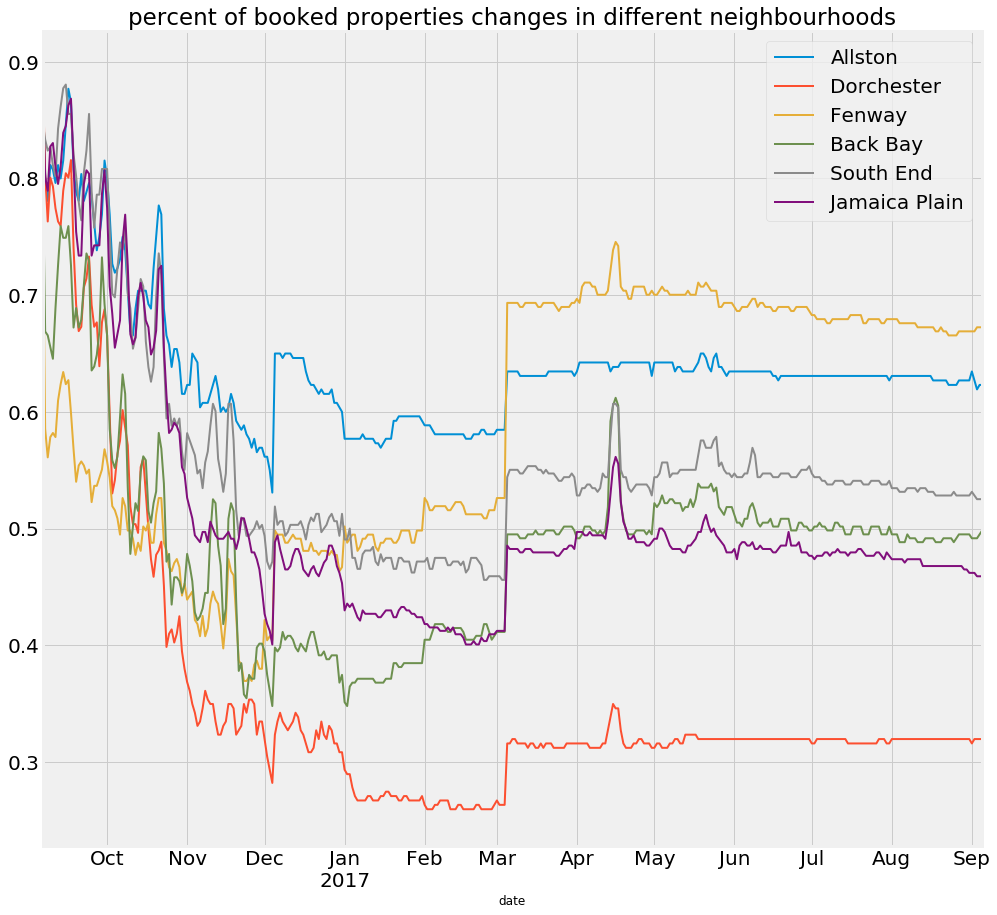

In [1017]:
#plot booking rate for top 6 neighbourhoods
ava=popular.loc[popular.available=='f'].groupby(['date','neighbourhood_cleansed']).count()['listing_id']
total=popular.groupby(['date','neighbourhood_cleansed']).count()['listing_id']
temp=pd.concat([ava,total],axis=1)
temp.columns=['ava_count','total_count']
temp=temp.reset_index()
temp['percent of unavailable listings']=temp['ava_count']/temp['total_count']
temp.groupby('neighbourhood_cleansed').mean()['percent of unavailable listings'].sort_values()

temp=temp.pivot(columns='neighbourhood_cleansed',index='date',values='percent of unavailable listings')

temp[[ 'Allston','Dorchester','Fenway','Back Bay','South End','Jamaica Plain']].plot(figsize=(15,15),legend=True,linewidth=2)
plt.title('percent of booked properties changes in different neighbourhoods',size=23)
plt.legend(fontsize=20)

# Listing distribution analysis

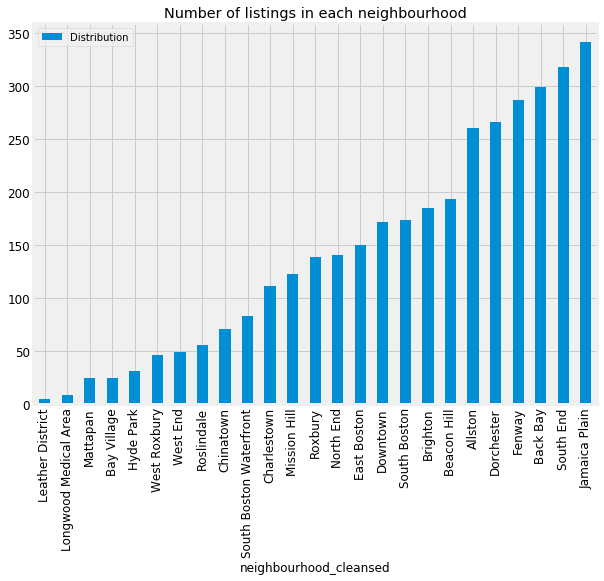

In [988]:
#plot listing distribution
subset=listing_b[['neighbourhood_cleansed','property_type','room_type','bedrooms','bathrooms','beds','accommodates','price','host_is_superhost','review_scores_rating']]
distr=subset.groupby('neighbourhood_cleansed').count().reset_index()[['neighbourhood_cleansed','price']].sort_values(by=['price'])
distr.columns=['neighbourhood_cleansed','Distribution']

distr.plot(x='neighbourhood_cleansed',y='Distribution',kind='bar' ,legend=True,figsize=(9,7),fontsize=12,title=
          'Number of listings in each neighbourhood')

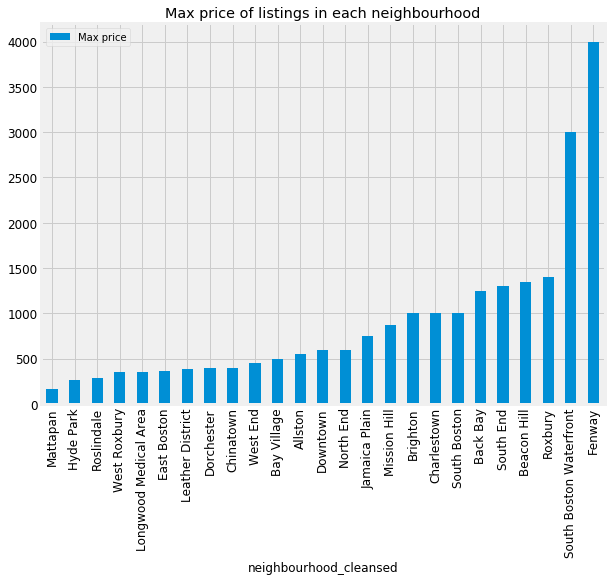

In [1046]:
# Max price across different neighbourhood
avg_price=subset.groupby(['neighbourhood_cleansed']).max()['price']
avg_price
avg_price=avg_price.reset_index()
avg_price.columns=['neighbourhood_cleansed','Max price']

avg_price.sort_values(by=['Max price']).plot(kind='bar',x='neighbourhood_cleansed',y='Max price',legend=True,
                                                figsize=(9,7),fontsize=12,title='Max price of listings in each neighbourhood')

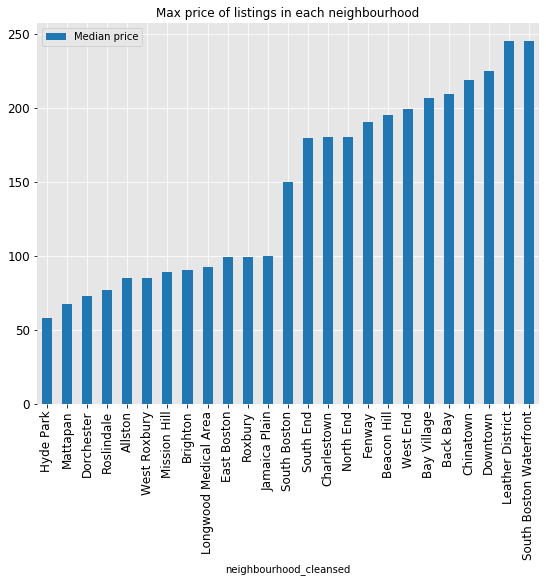

In [7]:
# avg price across different neighbourhood
avg_price=subset.groupby(['neighbourhood_cleansed']).median()['price']
avg_price
avg_price=avg_price.reset_index()
avg_price.columns=['neighbourhood_cleansed','Median price']

avg_price.sort_values(by=['Median price']).plot(kind='bar',x='neighbourhood_cleansed',y='Median price',legend=True,
                                                figsize=(9,7),fontsize=12,title='Max price of listings in each neighbourhood')

# Price prediction model

id                                 0.000000
host_id                            0.000000
host_response_rate                12.692308
host_acceptance_rate              12.692308
host_listings_count                0.000000
host_total_listings_count          0.000000
latitude                           0.000000
longitude                          0.000000
accommodates                       0.000000
bathrooms                          0.000000
bedrooms                           0.000000
beds                               0.000000
price                              0.000000
weekly_price                      74.763314
monthly_price                     75.355030
security_deposit                  63.076923
cleaning_fee                      30.887574
guests_included                    0.000000
extra_people                       0.000000
minimum_nights                     0.000000
maximum_nights                     0.000000
availability_30                    0.000000
availability_60                 

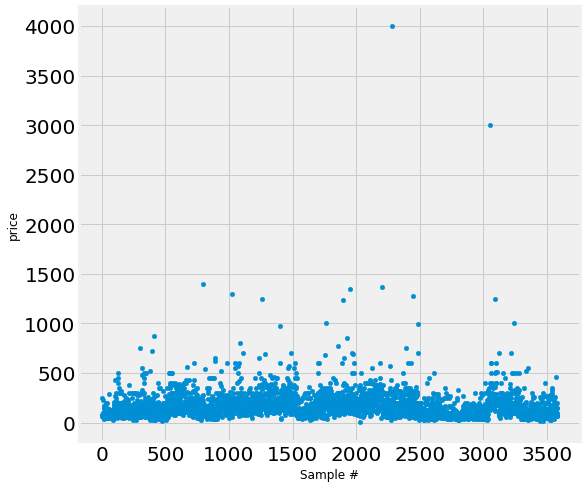

In [1293]:
# plot price distribution scatter plot
plot=listing_b.price.reset_index()
plot.columns=['Sample #','price']
plot.plot(kind='scatter',x='Sample #',y='price',figsize=(8,8))


# calculate IQR, lower and upper range to remove outliers
price_sort=sorted(df.price)
Q1,Q3 = np.percentile(price_sort , [25,75])
IQR = Q3 - Q1
lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

#remove outliers
listing_b=listing_b.loc[listing_b.price<upper,:]

# get numerical variables and fill missing values with mean
listing_b_num=listing_b.select_dtypes(include=['float','int64'])

#check percentage of missing values for numerical variables
print(listing_b_num.isnull().sum()/len(listing_b)*100)
listing_b_num=listing_b_num.apply(lambda x: x.fillna(x.mean()))

#drop columns 
listing_b_num=listing_b_num.drop(columns=['weekly_price','monthly_price','security_deposit','guests_included','reviews_per_month',\
'id','host_id','host_listings_count'])



In [1282]:
# get categorical variables and create dummies
cat_lst=['bed_type','room_type','property_type','is_location_exact',\
        'neighbourhood_cleansed','host_is_superhost']
listing_b_cat=pd.get_dummies(listing_b[cat_lst],drop_first=True,dummy_na=True)

#combine numerical and categorical datasets
df=pd.concat([listing_b_num,listing_b_cat],axis=1)

#create model 
X=df.drop(columns=['price'])
y=df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

models=[forest(n_estimators=150),linear(normalize=True),Ridge(alpha =0.05, normalize=True)]
names=['RandomeForest','LinearRegression','Ridge']

# test three models' performance and evaluate
for i in range(len(models)):
    model1=models[i]
    model1=model1.fit(X_train,y_train)
    pred=model1.predict(X_test)

    mae_train=mean_absolute_error(y_train,model1.predict(X_train))
    r2_train=r2_score(y_train,model1.predict(X_train))
    mae_test= mean_absolute_error(y_test, pred)
    r2_test=r2_score(y_test, pred)

    print( names[i],' MAE_test ',mae_test)
    print(names[i],' R2_test ',r2_test)

    print(names[i],' MAE_train ',mae_train)
    print(names[i],' R2_train ',r2_train)

RandomeForest  MAE_test  31.527784352399735
RandomeForest  R2_test  0.716433568290152
RandomeForest  MAE_train  11.550154973231896
RandomeForest  R2_train  0.960999705012361
LinearRegression  MAE_test  36.76365797722984
LinearRegression  R2_test  0.6385176703390409
LinearRegression  MAE_train  34.717012275306374
LinearRegression  R2_train  0.6723036913800504
Ridge  MAE_test  36.936824405641374
Ridge  R2_test  0.6375936767813349
Ridge  MAE_train  34.86669124736513
Ridge  R2_train  0.6707174210371011


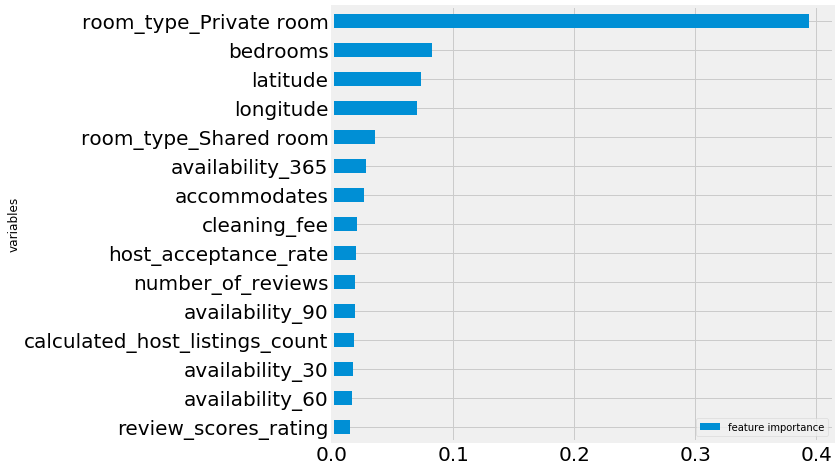

In [1285]:
#get RandomForest feature importance rank
model=forest(n_estimators=150).fit(X_train,y_train)
pred=model.predict(X_test)
importance=pd.DataFrame({'variables':X_train.columns,'feature importance':model.feature_importances_}).\
                                                    sort_values(by=['feature importance'],ascending=False)
importance.iloc[:15,:].sort_values(by=['feature importance']).plot(kind='barh',y='feature importance',x='variables',figsize=[8,8])


# Popular review word counts

In [1298]:
# drop rows with no comment
review_b.dropna(subset=['comments'],inplace=True)
review_b.comments=review_b.comments.str.lower()

# get listing id and comments pair
review_dic=dict(zip(review_b.listing_id,review_b.comments))

review_dic={}
ids=review_b.listing_id.unique()
for i in ids:
    comment=review_b.loc[review_b.listing_id==i,'comments'].to_list()
    comment=' '.join(comment)
    comment=comment.translate(str.maketrans('', '', string.punctuation))
    comment=comment.split()
    review_dic[i]=comment


In [1295]:
# combine NPL stop words and a selected stop words from this dataset
stop_words=stopwords.words('english')
mylist = [ 'could','would','boston','us','away','also','great','nice','apartment','room','house','home','place','alex','bob','like',
          'good','days','recommend','everything','get','even','made','staying','back','needed','de','little','one','two','definitely',
          'well','wonderful','always','fine','excellent','day','really','perfect','3','4','5','stay','around']

# get review word counts and sort in a descending order
stop_words.extend(mylist)
top={}
for i in review_dic.keys():

    temp_id=dict(Counter([word for word in review_dic[i] if word not in stop_words]))
    for idx, (k,v) in enumerate(temp_id.items()):
        if k=='walking':
            k='walk'
        if k in top.keys():
            top[k]=top[k]+v
        else:           
            top[k]=v
top=dict(sorted(top.items(),key=lambda item:item[1],reverse=True))            

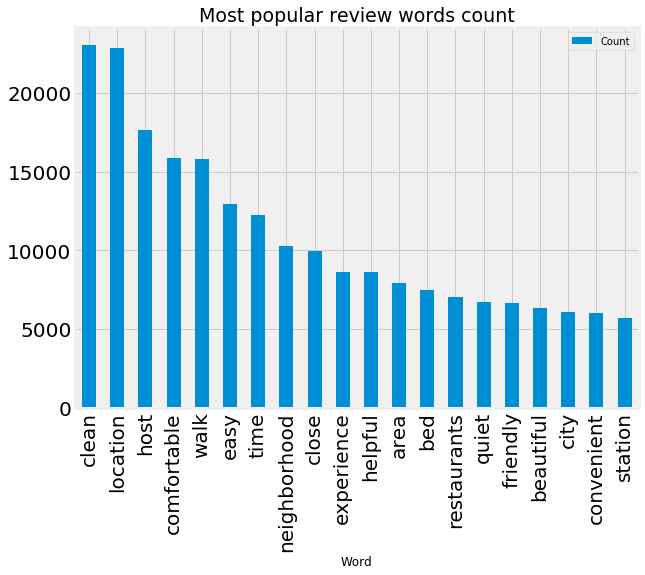

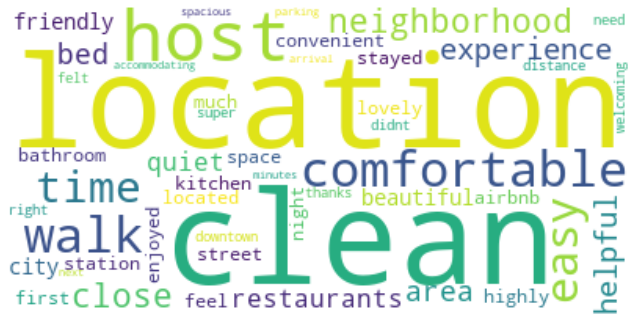

In [1296]:
# plot word count bar chart
df_top=pd.DataFrame(top.items(),columns=['Word','Count'])
df_top.iloc[:20,:].plot(kind='bar',x='Word',y='Count',figsize=(9,7))
plt.title('Most popular review words count',size=19)
words=''

#plot word cloud
for i in range(50):
    words+=(df_top.iloc[i,0]+' ')*df_top.iloc[i,1]
wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3,contour_color='firebrick',collocations = False)

wordcloud.generate(words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()